<a href="https://colab.research.google.com/github/UKJaagadhep/Data-science-and-machine-learning/blob/main/Extractive%20Question%20Answering%20with%20HuggingFace%20Transformers/Extractive_Question_Answering_with_HuggingFace_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import evaluate
from datasets import load_dataset
from transformers import create_optimizer
from transformers import LongformerTokenizerFast, TFLongformerForQuestionAnswering
from transformers import DebertaTokenizerFast
from transformers import DistilBertTokenizerFast, TFDistilBertForQuestionAnswering
from tensorflow.keras.optimizers import Adam

# **DATA PREPARATION**

In [3]:
#dataset = load_dataset("covid_qa_deepset")
dataset = load_dataset("squad")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [5]:
dataset['train'][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [6]:
dataset['train'][1]

{'id': '5733be284776f4190066117f',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'What is in front of the Notre Dame Main Building?',
 'answers': {'text': ['a copper statue of Christ'], 'answer_start': [188]}}

In [7]:
dataset['train'][1]['context'][2003 : 2003 + len(dataset['train'][1]['answers']['text'][0])]

''

In [8]:
model_id_ = "microsoft/deberta-base"
tokenizer = DebertaTokenizerFast.from_pretrained(model_id_)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [9]:
model_id = "allenai/longformer-large-4096-finetuned-triviaqa"
_tokenizer_ = LongformerTokenizerFast.from_pretrained(model_id)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

In [10]:
tokenizer_ = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [11]:
max_length = 1024

In [12]:
tokenized_example = tokenizer_(
    dataset['train'][0]['question'],
    dataset['train'][0]['context'],
    truncation = "only_second",
    max_length = max_length,

    stride = 64,
    return_overflowing_tokens = True,

    return_offsets_mapping = True,
    padding = "max_length"
    )

In [13]:
tokenized_example.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [14]:
tokenized_example

{'input_ids': [[101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017, 11342, 1998, 1996, 2

In [15]:
for i, chunk in enumerate(tokenized_example['input_ids']):
  print("CHUNK ", i+1, "-----> ", tokenizer_.decode(chunk), "\n\n")

CHUNK  1 ----->  [CLS] to whom did the virgin mary allegedly appear in 1858 in lourdes france? [SEP] architecturally, the school has a catholic character. atop the main building's gold dome is a golden statue of the virgin mary. immediately in front of the main building and facing it, is a copper statue of christ with arms upraised with the legend " venite ad me omnes ". next to the main building is the basilica of the sacred heart. immediately behind the basilica is the grotto, a marian place of prayer and reflection. it is a replica of the grotto at lourdes, france where the virgin mary reputedly appeared to saint bernadette soubirous in 1858. at the end of the main drive ( and in a direct line that connects through 3 statues and the gold dome ), is a simple, modern stone statue of mary. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [16]:
sample_mapping = tokenized_example.pop("overflow_to_sample_mapping")
offset_mapping = tokenized_example.pop("offset_mapping")

tokenized_example["start_positions"] = [] #e.g. [152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] token index of the start of the answer in the particular chunk with the answer
tokenized_example["end_positions"] = [] #e.g. [172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] token index of the end of the answer in the particular chunk with the answer

In [17]:
for i, offsets in enumerate(offset_mapping):

  if len(dataset['train'][0]['answers']['answer_start']) == 0: #There is no answer for that question within that whole context
    tokenized_example["start_positions"].append(0)
    tokenized_example["end_positions"].append(0)

  else:
    start_char = dataset['train'][0]['answers']['answer_start'][0]
    end_char = start_char + len(dataset['train'][0]['answers']['text'][0])

    found = 0
    start_token_position = 0
    end_token_position = 0

    #FINDING START AND END TOKEN POSITIONS
    for j, offset in enumerate(offsets):
      if offset[0] <= start_char and offset[1] >= start_char and found == 0:
        start_token_position = j
        end_token_position = max_length #initializing end_token_position in case answer exceeds out of the chunk
        found = 1

      if offset[1] >= end_char and found == 1:
        end_token_position = j #answer starts and ends within the chunk
        break

    tokenized_example['start_positions'].append(start_token_position)
    tokenized_example['end_positions'].append(end_token_position)

In [18]:
print(tokenized_example['start_positions'])
print(tokenized_example['end_positions'])

[130]
[137]


In [19]:
print(tokenized_example.keys())
tokenized_example

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])


{'input_ids': [[101, 2000, 3183, 2106, 1996, 6261, 2984, 9382, 3711, 1999, 8517, 1999, 10223, 26371, 2605, 1029, 102, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017, 11342, 1998, 1996, 2

In [20]:
def preprocess_function(dataset):

  #UNBATCHING
  questions = [q.lstrip() for q in dataset["question"]]
  paragraphs = [p.lstrip() for p in dataset["context"]]

  tokenized_examples = tokenizer_(
    questions,
    paragraphs,
    truncation = "only_second",
    max_length = max_length,
    stride = 64,
    return_overflowing_tokens = True,
    return_offsets_mapping = True,
    padding = "max_length",
  )

  sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
  offset_mapping = tokenized_examples.pop("offset_mapping")

  tokenized_examples["start_positions"] = [] #[152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] token index of the start of the answer in the particular chunk with the answer
  tokenized_examples["end_positions"] = [] #[172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] token index of the end of the answer in the particular chunk with the answer

  for i, offsets in enumerate(offset_mapping):
    sample_index = sample_mapping[i]

    if len(dataset['answers'][sample_index]['answer_start']) == 0: #There is no answer for that question within that whole context
      tokenized_examples["start_positions"].append(0)
      tokenized_examples["end_positions"].append(0)

    else:
      start_char = dataset["answers"][sample_index]['answer_start'][0]
      end_char = start_char + len(dataset["answers"][sample_index]['text'][0])

      found = 0
      start_token_position = 0
      end_token_position = 0

      #FINDING START AND END TOKEN POSITIONS
      for j, offset in enumerate(offsets):
        if offset[0] <= start_char and offset[1] >= start_char and found == 0:
          start_token_position = j
          end_token_position = max_length #initializing end_token_position in case answer exceeds out of the chunk
          found = 1

        if offset[1] >= end_char and found == 1:
          end_token_position = j #answer starts and ends within the chunk
          break

      tokenized_examples['start_positions'].append(start_token_position)
      tokenized_examples['end_positions'].append(end_token_position)

  return tokenized_examples

In [21]:
dataset["train"].column_names

['id', 'title', 'context', 'question', 'answers']

In [22]:
tokenized_dataset = dataset.map(
    preprocess_function,
    batched = True,
    remove_columns = dataset["train"].column_names
)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [23]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 10570
    })
})

In [24]:
batch_size = 2 #since longformer tasks take a lot of memory

In [25]:
tf_dataset = tokenized_dataset["train"].to_tf_dataset(
    shuffle = True,
    batch_size = batch_size,
)

In [26]:
for i in tf_dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(2, 1024), dtype=int64, numpy=
array([[  101,  2003,  4526, ...,     0,     0,     0],
       [  101,  2054, 15799, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(2, 1024), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'start_positions': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([75, 94])>, 'end_positions': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 79, 101])>}


In [27]:
train_dataset = tf_dataset.take(int(0.9 * len(tf_dataset)))
val_dataset = tf_dataset.skip(int(0.9 * len(tf_dataset)))

# **MODELING**

In [28]:
model = TFDistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model.summary()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it

Model: "tf_distil_bert_for_question_answering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66364418 (253.16 MB)
Trainable params: 66364418 (253.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#model = TFLongformerForQuestionAnswering.from_pretrained(model_id)
#model.summary()

# **TRAINING**

In [29]:
num_epochs = 3
num_train_steps = len(train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr = 2e-5,
    num_warmup_steps = 0,
    num_train_steps = num_train_steps,
)
model.compile(optimizer = optimizer,
              run_eagerly = True
              )

In [32]:
history = model.fit(train_dataset.take(400), validation_data = val_dataset.take(50), epochs = 5)

Epoch 1/5
400/400 [==============================] - 332s 830ms/step - loss: 4.1680 - val_loss: 3.8535
Epoch 2/5
400/400 [==============================] - 317s 794ms/step - loss: 3.2384 - val_loss: 3.0440
Epoch 3/5
400/400 [==============================] - 312s 782ms/step - loss: 2.7954 - val_loss: 2.4123
Epoch 4/5
400/400 [==============================] - 311s 778ms/step - loss: 2.4984 - val_loss: 2.4067
Epoch 5/5
400/400 [==============================] - 312s 780ms/step - loss: 2.3325 - val_loss: 2.0702


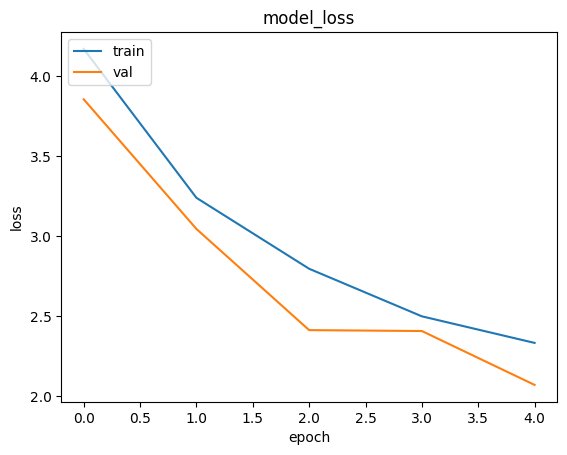

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

# **TESTING**

In [41]:
question = "What is the evidence suggesting?"
text = "We know that the disease is caused by the SARS-CoV-2 virus, which spreads between people in several different ways.Current evidence suggests that the virus spreads mainly between people who are in close contact with each other, for example at a conversational distance.The virus can spread from an infected person’s mouth or nose in small liquid particles when they cough, sneeze, speak, sing or breathe. Another person can then contract the virus when infectious particles that pass through the air are inhaled at short range (this is often called short-range aerosol or short-range airborne transmission) or if infectious particles come into direct contact with the eyes, nose, or mouth (droplet transmission). The virus can also spread in poorly ventilated and/or crowded indoor settings, where people tend to spend longer periods of time. This is because aerosols can remain suspended in the air or travel farther than conversational distance (this is often called long-range aerosol or long-range airborne transmission). People may also become infected when touching their eyes, nose or mouth after touching surfaces or objects that have been contaminated by the virus. Further research is ongoing to better understand the spread of the virus and which settings are most risky and why. Research is also under way to study virus variants that are emerging and why some are more transmissible. For updated information on SARS-CoV-2 variants, please read the weekly epidemiologic updates."
inputs = tokenizer_(question, text, return_tensors = "tf")
outputs = model(**inputs)

answer_start_index = int(tf.math.argmax(outputs.start_logits, axis = -1)[0])
answer_end_index = int(tf.math.argmax(outputs.end_logits, axis = -1)[0])

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer_.decode(predict_answer_tokens)

'current evidence suggests that the virus spreads mainly between people who are in close contact with each other, for example at a conversational distance'

In [42]:
question = "What causes the disease?"
text = "We know that the disease is caused by the SARS-CoV-2 virus, which spreads between people in several different ways.Current evidence suggests that the virus spreads mainly between people who are in close contact with each other, for example at a conversational distance.The virus can spread from an infected person’s mouth or nose in small liquid particles when they cough, sneeze, speak, sing or breathe. Another person can then contract the virus when infectious particles that pass through the air are inhaled at short range (this is often called short-range aerosol or short-range airborne transmission) or if infectious particles come into direct contact with the eyes, nose, or mouth (droplet transmission). The virus can also spread in poorly ventilated and/or crowded indoor settings, where people tend to spend longer periods of time. This is because aerosols can remain suspended in the air or travel farther than conversational distance (this is often called long-range aerosol or long-range airborne transmission). People may also become infected when touching their eyes, nose or mouth after touching surfaces or objects that have been contaminated by the virus. Further research is ongoing to better understand the spread of the virus and which settings are most risky and why. Research is also under way to study virus variants that are emerging and why some are more transmissible. For updated information on SARS-CoV-2 variants, please read the weekly epidemiologic updates."
inputs = tokenizer_(question, text, return_tensors = "tf")
outputs = model(**inputs)

answer_start_index = int(tf.math.argmax(outputs.start_logits, axis = -1)[0])
answer_end_index = int(tf.math.argmax(outputs.end_logits, axis = -1)[0])

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer_.decode(predict_answer_tokens)

'sars - cov - 2 virus'